# Importing Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

# Color

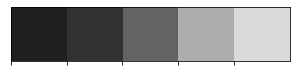

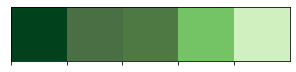

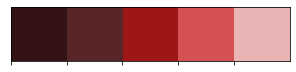

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

# Data Preperation

In [5]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [7]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        

        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 762/762 [00:02<00:00, 255.58it/s]


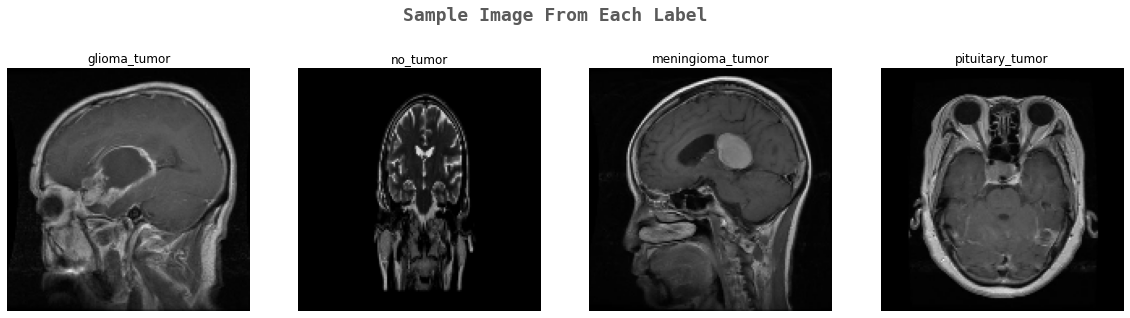

In [8]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [9]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [10]:
X_train.shape

(2512, 150, 150, 3)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(2512, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values

In [13]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Transfer Learning

In [14]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16711680/16705208 [==============================] - 0s 0us/step


In [15]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [17]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [19]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

# Training The Model

In [20]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
64/64 [==============================] - 243s 4s/step - loss: 0.4298 - accuracy: 0.8338 - val_loss: 1.2195 - val_accuracy: 0.7832

Epoch 00001: val_accuracy improved from -inf to 0.78319, saving model to effnet.h5
Epoch 2/15
64/64 [==============================] - 231s 4s/step - loss: 0.1634 - accuracy: 0.9415 - val_loss: 0.5380 - val_accuracy: 0.8496

Epoch 00002: val_accuracy improved from 0.78319 to 0.84956, saving model to effnet.h5
Epoch 3/15
64/64 [==============================] - 231s 4s/step - loss: 0.0979 - accuracy: 0.9666 - val_loss: 0.5727 - val_accuracy: 0.8451

Epoch 00003: val_accuracy did not improve from 0.84956
Epoch 4/15
64/64 [==============================] - 238s 4s/step - loss: 0.0556 - accuracy: 0.9818 - val_loss: 0.8211 - val_accuracy: 0.7743

Epoch 00004: val_accuracy did not improve from 0.84956

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/15
64/64 [==============================] - 237s 4s/step - loss:

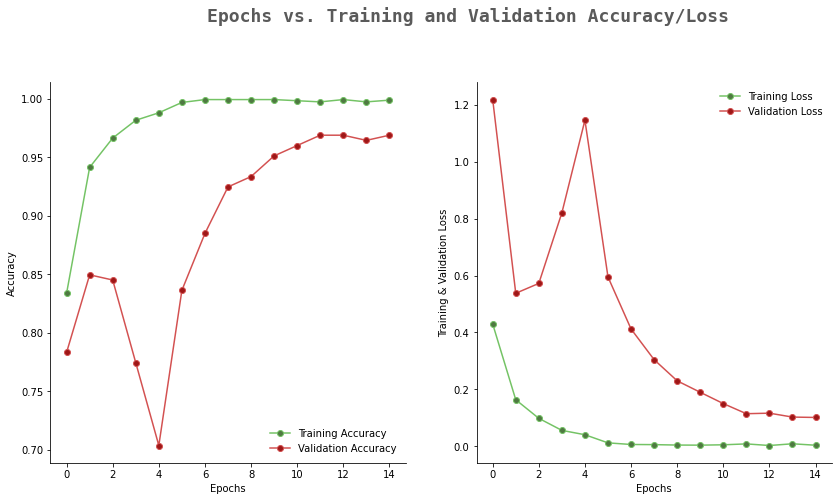

In [25]:
filterwarnings('ignore')

epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()

ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

# Prediction

In [26]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [27]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        86
           1       0.97      0.97      0.97        37
           2       0.96      0.94      0.95        47
           3       0.99      0.99      0.99        82

    accuracy                           0.97       252
   macro avg       0.97      0.97      0.97       252
weighted avg       0.97      0.97      0.97       252



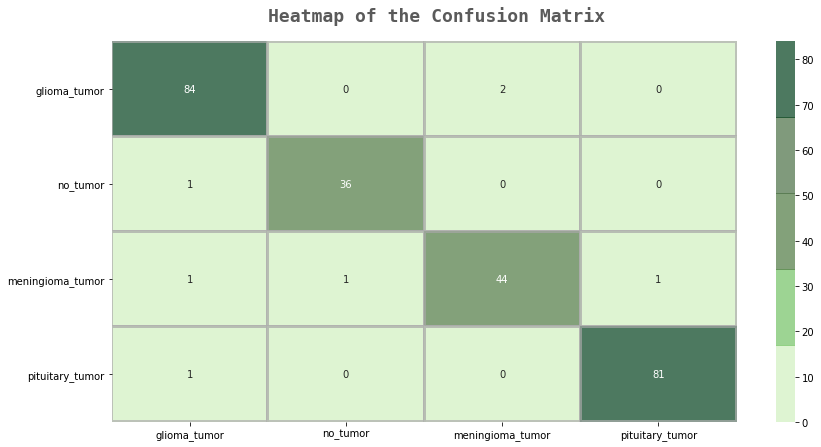

In [28]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

# Saving Model

In [31]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
model.save("mymodel1.h5")